In [10]:
from pathlib import Path
import numpy as np
import copy as cp
# from gpcam.gp_optimizer import fvGPOptimizer
import matplotlib.pyplot as plt
from numpy.random import default_rng
import time
from typing import *
from tqdm.auto import tqdm
from datetime import datetime
import h5py

from itertools import product


In [11]:
from gpcam.gp_optimizer import fvGPOptimizer


In [79]:
def pretty_print_time(t):
    """Print time as hh:mm:ss"""
    h = int(t//3600)
    m = int((t%3600)//60)
    s = int(t%60)
    return f'{h:02d}:{m:02d}:{s:02d}'

In [38]:
source_file =  Path(r"D:\Data\2023\05May\Z018\Z018_12_1.h5")
with h5py.File(source_file, 'r', swmr=True) as f:
    all_spectra = f['Entry/Data/TransformedData'][()]
    measured_positions = f['Entry/Data/ScanDetails/SetPositions'][:,:2]
    d0 = f['Entry/Data/ScanDetails/Dim1_length'][()]
    d1 = f['Entry/Data/ScanDetails/Dim2_length'][()]
    map_shape = d1,d0

all_positions = np.array(tuple(product(range(map_shape[0]),range(map_shape[1]))))
# print(*zip(all_positions,measured_positions[:5]),sep='\n')
# all_positions[:5], all_positions.shape
print(all_spectra.shape,all_positions.shape,map_shape,np.prod(map_shape))

(1116, 640, 400) (1116, 2) (31, 36) 1116


In [39]:
print(*zip(all_positions,measured_positions[:5]),sep='\n')

(array([0, 0]), array([-1200., -5200.]))
(array([0, 1]), array([-1.19800000e+03, -9.99999999e+08]))
(array([0, 2]), array([-1.19600000e+03, -9.99999999e+08]))
(array([0, 3]), array([-1.19400000e+03, -9.99999999e+08]))
(array([0, 4]), array([-1.19200000e+03, -9.99999999e+08]))


In [40]:
scan_limits = np.array([all_positions.min(axis=0),all_positions.max(axis=0)]).T

In [41]:
def reduce(spectrum) -> Tuple[float]:
    """Reduce a spectrum to its mean and std"""
    return spectrum.mean(), spectrum.std()

In [42]:
all_reduced = []
for s in tqdm(all_spectra, total=len(all_spectra), desc="Reducing spectra"):
    all_reduced.append(reduce(s))
all_reduced = np.array(all_reduced)

Reducing spectra:   0%|          | 0/1116 [00:00<?, ?it/s]

In [43]:
reduced_maps = all_reduced.reshape(*map_shape,2)

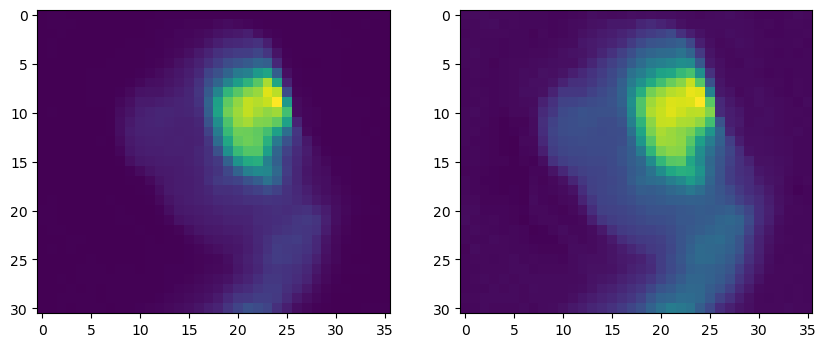

In [44]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(reduced_maps[:,:,0])
ax[1].imshow(reduced_maps[:,:,1])

In [45]:
def ndim_aqfunc(x, gp):
    """Compute the acquisition function for a given GP and a given point"""
    a = 1.5  #####change here, 3.0 for 95 percent confidence interval
    norm = 1.0
    ret = None
    for i in range(gp.input_dim-1):
        x_pred=np.c_[x,np.zeros(x.shape[0])+i].reshape(-1,gp.input_dim)
        cov = gp.posterior_covariance(x_pred)["v(x)"]
        if ret is None:
            ret = cov
        else:
            ret += cov
            
    ret=a * np.sqrt(ret)

    for i in range(gp.input_dim-1):
        x_pred=np.c_[x,np.zeros(x.shape[0])+i].reshape(-1,gp.input_dim)
        mean = gp.posterior_mean(x_pred)["f(x)"]
        ret += norm * mean

    return ret


In [61]:

def manhattan_distance(x,y):
    return np.abs(x[0]-y[0])+np.abs(x[1]-y[1])

def closest_point_on_grid(x,map_shape=map_shape):
    """Find the closest point in a grid to a given point"""
    grid = np.array(tuple(product(range(map_shape[0]),range(map_shape[1]))))
    return grid[np.linalg.norm(grid-x,axis=1).argmin()]


def scan_time(positions, cost_func_params):
    return np.sum([movement_cost(positions[i-1],positions[i],cost_func_params) for i in range(1,len(positions))])


In [62]:

def movement_cost(
        origin: tuple, 
        x: tuple, 
        cost_func_params: dict = None, 
        verbose: bool = False
    ) -> float:
    """Compute the cost of moving from x to y
    
    Args:
        x (tuple): starting position
        y (tuple): ending position
        cost_func_params (dict): dictionary of parameters for the cost function
            - speed (float): speed of the scanner, expressed in mm/s
            - dwell_time (float): dwell time, expressed in s
            - dead_time (float): dead time, expressed in s
            - point_to_um (float): conversion factor from mm to seconds
    
    Returns:
        float: cost of moving from x to y, expressed in seconds

    """
    x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    if cost_func_params is None:
        cost_func_params = {}
    else:
        cost_func_params = cost_func_params.copy()
    speed = cost_func_params.pop('speed',250)
    dwell_time = cost_func_params.pop('dwell_time',0.5)
    dead_time = cost_func_params.pop('dead_time',0.6)
    point_to_um = cost_func_params.pop('point_to_um',1.0)
    weight = cost_func_params.pop('weight',1.0)
    if len(cost_func_params) > 0:
        raise ValueError(f"Unrecognized parameters: {cost_func_params.keys()}")
    distance = manhattan_distance(origin,x) * point_to_um
    time = weight * distance / speed  + dwell_time + dead_time
    if verbose:
        print(f"Distance: {distance:.2f} um, Time: {time:.2f} s"
            f" (dwell: {dwell_time:.2f} s, dead: {dead_time:.2f} s)" 
        )
    return time

def cost_function(origin, x:Sequence[tuple], cost_func_params: dict = None) -> float:
    cost = []
    for xx in x:
        cost.append(movement_cost(origin,xx,cost_func_params))
    return np.array(cost).T


In [69]:

def measurement_loop(
    init_positions, 
    init_values,
    gp,
    n_points=200,
    train_every=20,
    train_at = None,
    verbose=False,
) -> None:
        
    values = init_values.copy()
    positions = init_positions.copy()
    for i in tqdm(range(n_points), desc="Acquisition loop"):
        gp.tell(positions, values)
        next_pt = gp.ask(position=positions[-1],**ask_pars)
        next_on_grid = closest_point_on_grid(next_pt['x'])
        next_pt.update({'pos':next_on_grid})
        next_val = reduced_maps[next_pt['pos'][0],next_pt['pos'][1],:][None,...]

        next_pos = np.array(next_pt['pos'])[None,:]
        # print(next_val,next_pos, sep='\n')
        positions = np.append(positions, next_pos, axis=0)
        values = np.append(values, next_val, axis=0)
        if train_at is None:
            train_at = []
        if i % train_every == 0 or i in train_at:
            t0 = time.time()
            gp.train_gp(**train_pars)
            print(f"Training at i={i} took {time.time()-t0:.2f} s")
    return positions, values
            



In [70]:

def vis_map_with_path(positions,values,reduced_maps=reduced_maps,ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(6,5))
    ax.imshow(reduced_maps[...,0],alpha=0.5)
    # ax[1].imshow(reduced_maps[...,0],alpha=0.5)
    ax.plot(positions[:,1],positions[:,0],'r-',alpha=0.5,linewidth=.5)
    ax.scatter(positions[:,1],positions[:,0],s=10)#,c=values[:,0],cmap='viridis')
    # ax[1].scatter(positions[:,1],positions[:,0],s=10)#c=values[:,0],cmap='viridis')


In [71]:
optimizer_pars = {
    'input_space_dimension': 2,
    'output_space_dimension': 1,
    'output_number': 2,
    'input_space_bounds': scan_limits,
}
hyperparameter_bounds = np.array(
    [[0.001,1e9],[1,1000],[1,1000],[1,1000],[1,1000]]
)
init_hyperparameters = np.array(
        [4.71907062e+06, 4.07439017e+02, 3.59068120e+02,4e2,4e2]
)
train_pars = {
    'hyperparameter_bounds': hyperparameter_bounds,
    'pop_size': 20,
    'tolerance': 1e-6,
    'max_iter': 2,
}
train_async_pars = {
    'hyperparameter_bounds':hyperparameter_bounds,
    'init_hyperparameters': init_hyperparameters,
    'max_iter': 10000,
    'local_optimizer': "L-BFGS-B",
    'global_optimizer': "genetic",
    'constraints': (),
    'deflation_radius': None,
    'dask_client': None,
}
train_gp_async_pars = {
    'hyperparameter_bounds':hyperparameter_bounds,
    'max_iter': 10000,
    'dask_client': None,
    'deflation_radius': None,
    'constraints': (),
    'local_method': "L-BFGS-B",
    'global_method': "genetic",
}
fvgp_pars = {
    'init_hyperparameters' : init_hyperparameters,
    'compute_device': 'cpu',
    'gp_kernel_function': None,
    'gp_mean_function': None,
    'use_inv':False,
    'ram_economy': True,
}
ask_pars = {
    'n': 1, 
    'acquisition_function': ndim_aqfunc, 
    'bounds': None,
    'method': 'global', 
    'pop_size': 20, 
    'max_iter': 10, 
    'tol': 10e-6, 
    'x0': None, 
    'dask_client': None,
}
cost_func_params = {
    'speed':300,
    'dwell_time':1.0,
    'dead_time':0.6,
    'point_to_um':15,
    'weight':1.0,
}

# run GP

In [72]:
center_idx = len(all_positions)//2
init_positions = np.array([
    all_positions[center_idx],
    all_positions[center_idx],
])
init_values = np.array([
    np.array(reduce(all_spectra[center_idx])),
    np.array(reduce(all_spectra[center_idx])),
])
init_positions, init_values


(array([[15, 18],
        [15, 18]]),
 array([[0.04084378, 0.16344479],
        [0.04084378, 0.16344479]]))

In [73]:
gp = fvGPOptimizer(**optimizer_pars)
gp.tell(init_positions,init_values)
gp.init_fvgp(**fvgp_pars)
gp.train_gp(**train_pars)
positions = init_positions.copy()
values = init_values.copy()
gp.init_cost(cost_function,cost_func_params)
positions.shape, values.shape


((2, 2), (2, 2))

In [74]:
pos, vals = measurement_loop(
    init_positions, 
    init_values, 
    gp=gp,
    n_points=500, 
    train_every=50,
    train_at = [10, 20],
    verbose=True,
)


Acquisition loop:   0%|          | 0/500 [00:00<?, ?it/s]

Training at i=0 took 0.24 s
Training at i=10 took 0.31 s
Training at i=20 took 0.25 s
Training at i=50 took 1.18 s
Training at i=100 took 1.32 s
Training at i=150 took 2.26 s
Training at i=200 took 6.71 s
Training at i=250 took 11.27 s
Training at i=300 took 13.88 s
Training at i=350 took 21.33 s
Training at i=400 took 29.25 s
Training at i=450 took 35.52 s


NameError: name 'pos_nocost' is not defined

In [76]:

counts = list(dict(Counter(tuple(map(tuple,pos)))).values())
print(f'Number of repeated points: {sum(counts)-len(counts)}')

Number of repeated points: 456


array([[15, 18],
       [15, 18],
       [30, 18],
       ...,
       [ 9, 24],
       [ 9, 24],
       [ 9, 24]])

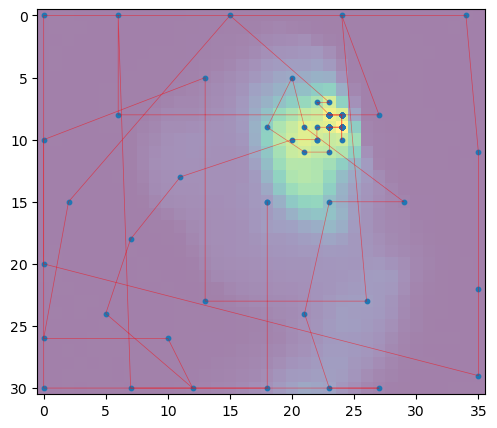

In [80]:
vis_map_with_path(pos, vals, reduced_maps=reduced_maps)

In [81]:
print(f'smart scan time:  ' +pretty_print_time(scan_time(pos,cost_func_params)))
print(f'raster scan time: ' +pretty_print_time(scan_time(all_positions,cost_func_params)))

smart scan time:  00:13:48
raster scan time: 00:31:32
